In [1]:
import matplotlib.pyplot as plt
%run utilities/voronoi_utils.py

In [6]:
def draw_pt(draw, pos, radius = 3, fill = (255,0,255)):
    draw.ellipse([tuple(pos - radius), tuple(pos + radius)], fill = fill)

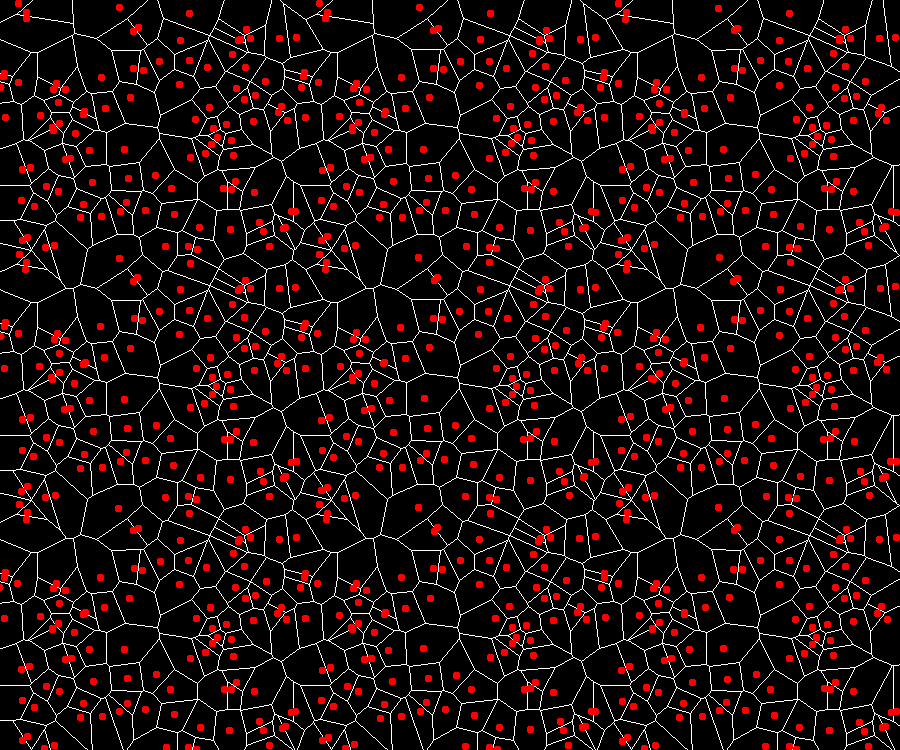

In [2]:
N = 100
size = width, height = 300, 250
total_size = 3 * width, 3 * height

pts = np.stack((np.random.randint(0, width, N), np.random.randint(0, height, N)), axis = -1)

# Create 9 copies of each points for tiling
decalX = np.array([width, 0.], dtype = "float")
decalY = np.array([0., height], dtype = "float")
pts = np.concatenate([pts + i*decalX + j*decalY for i in range(3) for j in range(3)])

# Jitter to avoid degenerate cases
pts = pts + np.random.normal(scale = 1/100., size = pts.shape)


voronoi = VoronoiGraph(pts)
img = voronoi.draw_img(total_size, display_points = True)
img

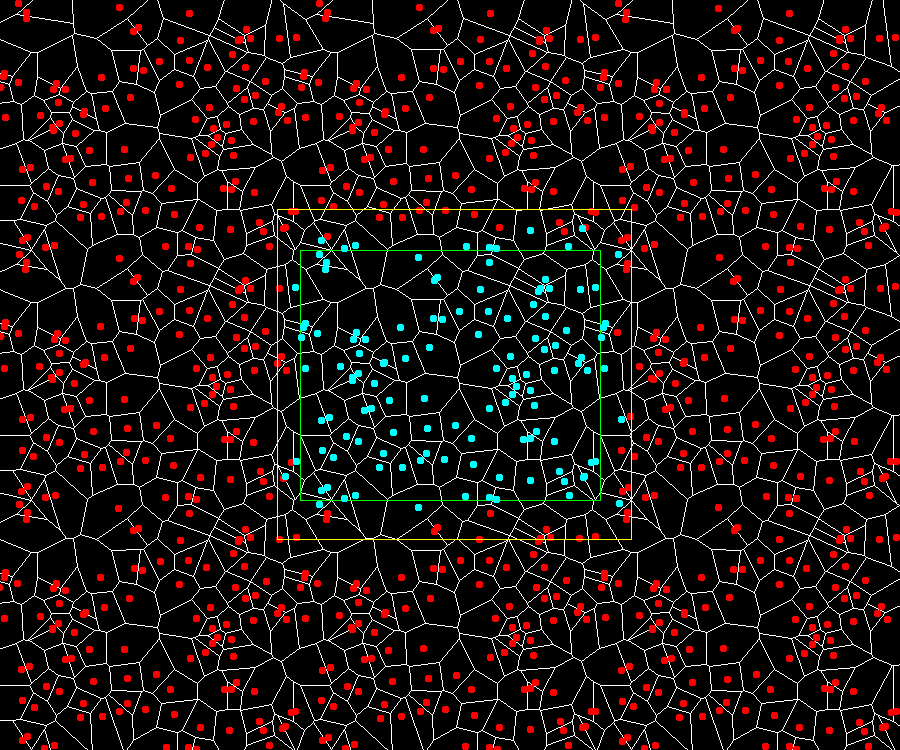

In [12]:
map_vor = voronoi.draw_img(total_size, display_points = True)

pt_to_draw = voronoi.points[0]
radius = 2

center = np.array([width, height])
size_r = np.array([width, height])

draw = ImageDraw.Draw(map_vor)
draw.rectangle([tuple(center), tuple(center + size_r)], outline = (0, 255, 0))

draw.rectangle([tuple(minPt), tuple(maxPt)], outline = (255, 255, 0))



for cell in cells:
    draw_pt(draw, cell.pt, fill = (0,255,255))

map_vor

In [4]:
cells = [cell for cell in voronoi.cells if cell.overlap(size_r, center)]
trim_pts = np.stack([edge.origin for cell in cells for edge in cell.edges] + [edge.end for cell in cells for edge in cell.edges if edge.bounded])
minPt = np.min(trim_pts, axis = 0) 
maxPt = np.max(trim_pts, axis = 0) 

In [27]:
size_img = size_r
w, h = size_img

img = np.full(size_img, 0.)

In [70]:
%%timeit
cells = [cell for cell in voronoi.cells if cell.overlap(size_r, center)]

size_img = size_r
w, h = size_img

img = np.full(size_img, 0.)

for cell in cells:
    
    
    all_edges = np.stack([edge.origin for edge in cell.edges] + [edge.end for edge in cell.edges if edge.bounded])
    minPt = np.min(all_edges, axis = 0)
    maxPt = np.max(all_edges, axis = 0)
    
    cell.iMin = (minPt - center).astype("int")
    cell.iMax = (maxPt - center).astype("int")
    cell.size_img = cell.iMax - cell.iMin
    cell.img = np.full(cell.size_img, 1.)
    
    # We create a coordinate array
    # Shape: w
    x = np.arange(cell.size_img[0]) + 0.5 + minPt[0] 
    # Shape: h
    y = np.arange(cell.size_img[1]) + 0.5 + minPt[1] 
    # Shape: (w, h, 2)
    coords = np.stack(np.meshgrid(x, y, indexing = "ij"), axis = 2)

    for edge in cell.edges:

        # Determining origin and inward-pointing normal of edge
        edge.normal = rotation.dot(edge.direction)
        if np.dot(edge.normal, cell.pt - edge.origin)  < 0:
            normal = - edge.normal
        else:
            normal = edge.normal
        
        # Calculating distance to edge
        dist = np.dot(coords - edge.origin, normal) / np.linalg.norm(normal)
        
        # Multiplying positive value of plane
        cell.img *= dist * (dist >= 0).astype("float")

    cell.img /= np.max(cell.img)

# Multiplying distances
img = np.full(size_img, 0.)
for cell in cells:
    iMin = np.maximum(cell.iMin, [0, 0]).astype("int")
    iMax = np.minimum(cell.iMax, size_img).astype("int")

    cropping_left = iMin - cell.iMin
    cropping_right = cell.size_img - (cell.iMax - iMax)
    img[iMin[0]:iMax[0], iMin[1]:iMax[1]] += cell.img[cropping_left[0]:cropping_right[0],
                                                      cropping_left[1]:cropping_right[1]]

227 ms ± 7.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


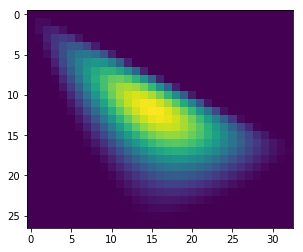

In [69]:
%%timeit
size = np.array(size_r)

cells = [cell for cell in voronoi.cells if cell.overlap(size, center)]

trim_pts = np.stack([edge.origin for cell in cells for edge in cell.edges] + [edge.end for cell in cells for edge in cell.edges if edge.bounded])
minPt = np.min(trim_pts, axis = 0) 
maxPt = np.max(trim_pts, axis = 0) 


size_img = tuple(int(g) for g in (maxPt - minPt))
w, h = size_img

img = np.full(size_img, 1.)

# We create a coordinate array
# Shape: w
x = np.arange(w) + 0.5 + minPt[0] 
# Shape: h
y = np.arange(h) + 0.5 + minPt[1] 
# Shapes: (w, h)
xv, yv = np.meshgrid(x, y, indexing = "ij")

# coordinate array
# Shape: (w, h, 2)
coords = np.stack((xv, yv), axis = 2)

for cell in cells:

    cell.mask = np.full_like(img, 1.)
    cell.dists = []

    for edge in cell.edges:

        # Determining origin and inward-pointing normal of edge
        edge.normal = rotation.dot(edge.direction)
        if np.dot(edge.normal, cell.pt - edge.origin)  < 0:
            normal = - edge.normal
        else:
            normal = edge.normal

        # Multiplying positive value of plane
        dist = np.dot(coords - edge.origin, normal) / np.linalg.norm(normal)
        cell.dists.append(dist)

        mult = (dist >= 0).astype("float")
        cell.mask *= mult

# Multiplying distances
for cell in cells:

    for edge, dist in zip(cell.edges, cell.dists):
        # Multiplying positive value of plane
        img *= cell.mask * dist + (1 - cell.mask) 

    # Cell-wise renormalization
    maximum = np.max(cell.mask * img)
    img /= cell.mask * maximum + (1 - cell.mask)

indexStart = (center - minPt).astype("int")
indexEnd = (center + size - minPt).astype("int")
img = img[indexStart[0] : indexEnd[0], indexStart[1] : indexEnd[1]]

7.09 s ± 403 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


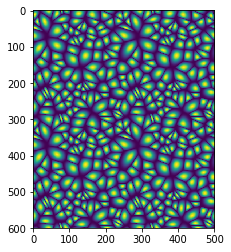

In [67]:
plt.imshow(np.tile(img, (2,2)))

In [55]:
cell.iMax - cell.iMin

array([21, 49])

In [53]:
[0,1,2,2][0:]

[]

In [ ]:
img = Image.new("RGB", (width + 1, height + 1), (0,0,0))
draw = ImageDraw.Draw(img)

for i in range(points.shape[0]):
    small_pt(draw, points[i], radius = 2)

img

In [ ]:
# Jitter to avoid uniformity
points_jitter = points + np.random.normal(scale = 1/5. * step_x, size = points.shape)

# Create 9 copies of each points for tiling
decalX = np.array([width, 0.], dtype = "float")
decalY = np.array([0., height], dtype = "float")
points_jitter = np.concatenate([points_jitter + i * decalX + j * decalY for i in range(3) for j in range(3)])

# Jitter to avoid degenerates due to tiling
points_jitter = points_jitter + np.random.normal(scale = 1/100., size = points_jitter.shape)

voronoi = VoronoiFill(points_jitter.tolist())



In [ ]:
voronoi.compute_cells()
img = voronoi.fill_img((2*width, 2*height), center = (-0.5 * width, -0.5 * height))

In [ ]:
plt.imsave("test_texture.png", 1 - img[ : height, : width], cmap = "Greys")

In [ ]:
def plane(origin, normal, coords):
    dot_product = np.dot(coords - origin, normal) > 0
    
    plane = np.full_like(dot_product, 0.)
    plane[dot_product] = 1.
    
    return plane

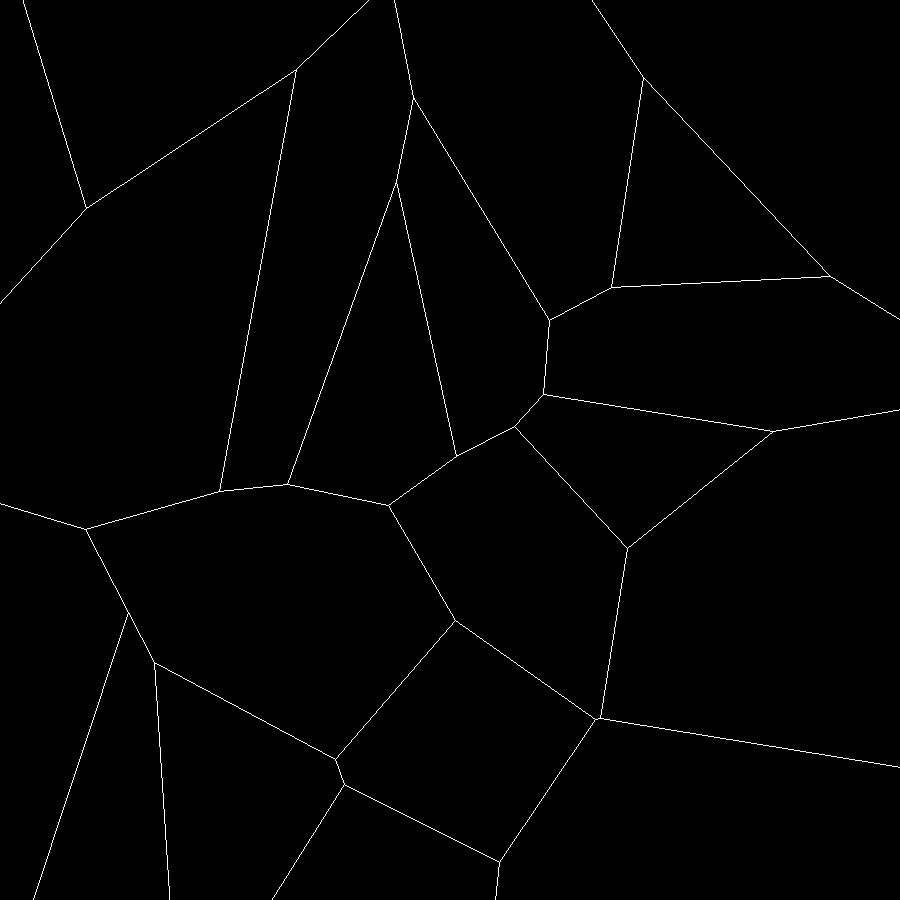

In [38]:
img

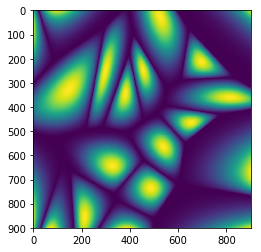

In [37]:
plt.imshow(voronoi.fill_img(size))

In [30]:
def fill_img2(voron, size):
    center = np.array([0.,0.])
    w, h = size

    img = np.full((w, h), 1.)

    # We create a coordinate array
    # Shape: w
    x = np.arange(w) + 0.5 - center[0]
    # Shape: h
    y = np.arange(h) + 0.5 - center[1]
    # Shapes: (w, h)
    xv, yv = np.meshgrid(x, y)

    # coordinate array
    # Shape: (w, h, 2)
    coords = np.stack((xv, yv), axis = 2)



    # Constructing masks for every cell

    for cell in voron.cells.values():

        cell.mask = np.full_like(img, 1.)
        cell.dists = []
        
        for edge in cell.edges:

            # Determining origin and inward-pointing normal of edge
            edge.origin = np.array(edge.origin)
            edge.normal = np.array([-edge.dir[1], edge.dir[0]])
            if np.dot(edge.normal, np.array(cell.pt) - edge.origin)  < 0:
                normal = - edge.normal
            else:
                normal = edge.normal

            # Multiplying positive value of plane
            dist = np.dot(coords - edge.origin, normal) / np.linalg.norm(normal)
            cell.dists.append(dist)

            mult = (dist >= 0).astype("float")
            cell.mask *= mult

    # Multiplying distances
    for cell in voron.cells.values():
        for edge, dist in zip(cell.edges, cell.dists):
            # Multiplying positive value of plane
            img *= cell.mask * dist + (1 - cell.mask) 

        # Cell-wise renormalization
        maximum = np.max(cell.mask * img)
        img /= cell.mask * maximum + (1 - cell.mask)
    return img

In [31]:
%timeit fill_img2(voronoi, size)

11.5 s ± 348 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%timeit voronoi.fill_img(size)

16.3 s ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
A = np.array([1.58, 0.67])
B = np.array([3.22, 1.65])
C = np.array([1.04, 3.13])
D = np.array([5.67, 1.79])


In [ ]:


def real_edge(pt1, pt2, boundary = False):
    toReturn = Edge(None, None, pt1, pt2 - pt1)
    if boundary:
        toReturn.add_boundary(pt2)
    return toReturn

In [ ]:
e1 = real_edge(A, B)
e2 = real_edge(C, D, True)

In [ ]:
e1.intersect(e2)

In [ ]:
e1.intersect_with_boundary(e2)

In [ ]:
img
#tile(img, 3 ,3)

    

In [ ]:
tile(img,2 ,2)

In [ ]:
a = np.array([2, 4 ,8])
a % 3

# Speed test

In [ ]:
import numpy as np

l = np.random.randint(15, size = (900, 900))
i_mask = np.random.randint(2, size = l.shape)
b_mask = (i_mask == 1)

def boolean_mask(n = 100):
    test = np.full_like(l, 0.)
    for i in range(n):
        test[b_mask] += l[b_mask]
    
def integer_mask(n = 100):
    test = np.full_like(l, 0.)
    for i in range(n):
        test += i_mask * l

In [ ]:
b_mask.astype("float")